# Goal

This code attempts to recreate the results in Alex Robel's (2019) paper on instability and probability skews using his simple stochastic ice-sheet model. The original code is found here: https://github.com/aarobel/StochasticMISI/blob/master/Noisy_GrowthRate_manuscript_rv2.m

Some parameters and names:
    1. xg == grounding line position
    2. omega == a glaciological parameter? gamma in Robel et al. (2019)? Could be omega in Robel et a. (2018)
    3. h == spatially averaged glacier thickness

In [1]:
# setup
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# set the default grid style
plt.rcParams['grid.color'] = 'k'
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['grid.linewidth'] = 0.5

In [2]:
# for reproducability, fix the random seed
np.random.seed(1)

In [3]:
# choose whether the runs will be done from scratch (ld_prev=0), or loaded from saved files (ld_prev=1)
ld_prev=1

# Define the Model Parameters

In [4]:
# define the number of ensemble members in the stochastic model
n_ensemble = int(1e4)
n_ens_plots = 100
nens_ss = np.arange(1,n_ensemble,np.floor(n_ensemble/n_ens_plots),dtype='int64')-1

In [5]:
# define a dictionary of parameters for the ice-sheet model, and then fill it
parameters = {
    
# Resolution of model
    'grid_n_nodes': 1000, # horizontal resolution
    'grid_gz_nodes': 203, # horizontal resolution in grounding zone
    
# Timing for model
    'year': 3600*24*365,} # length of a year [s]
parameters['nsteps'] = 1000
parameters['tfinal'] = parameters['nsteps']*parameters['year'] # total time of integration [s]

# Accumulation
parameters['accumrate'] = 0.35/parameters['year'] # accumulation rate [m/yr??]
parameters['accum_mean'] = 0.35/parameters['year']
parameters['accum_std'] = 0.3/parameters['year']

# Butressing
parameters['buttress'] = 0.4
parameters['buttress_mean'] = 0.4
parameters['buttress_std'] = 0

# Basal friction coefficient (Schoof 2007)
parameters['C_schoof'] = 7.624e6
parameters['C_mean'] = 7.624e6
parameters['C_std'] = 0
parameters['m_schoof'] = float(1/3)

# Bed characteristics
parameters['icedivide'] = 0
parameters['bedslope'] = -2e-3 # bed slope/depth [POSITIVE OR NEGATIVE?]
parameters['sill_min'] = 550e3
parameters['sill_max'] = 750e3
parameters['sill_slope'] = 2e-3 # sill slope

# Bed trigonometry
parameters['sin_amp'] = 0
parameters['sin_length'] = 20e3

# Grid parameters
parameters['n_elements'] = parameters['grid_n_nodes']-1 # number of finite elements, becomes length of h and N

# Glen's Law parameters
parameters['B_Glen'] = (4.227e-25**(-1/3))*np.ones((parameters['n_elements'],1),dtype='float64')
parameters['n_Glen'] = 3

# Physical parameters
parameters['rho'] = 917 # ice density [kg/m3]
parameters['rho_w'] = 1028 # ice density [kg/m3]
parameters['g'] = 9.81 # gravitational acceleration [m/s2]

# Run the Model to Equilibrium

### Setup

In [6]:
# grab the parameters we need for the equilibrium run
rho_i = parameters['rho']
rho_w = parameters['rho_w']
g = parameters['g']
n = parameters['n_Glen']
m = parameters['m_schoof']

year = parameters['year']
accum = parameters['accumrate']

A_glen = parameters['B_Glen'][0]**(-3)
C = parameters['C_schoof']

theta0 = 1 - parameters['buttress']
omega = ((A_glen*(rho_i*g)**(n+1) * (1-(rho_i/rho_w))**n / (4**n * C))**(1/(m+1))) * theta0**(n/(m+1))

beta = (m+n+3)/(m+1)
lamda = rho_w/rho_i

gz_frac = 1
b0_orig = parameters['icedivide']

In [7]:
# get the timesteps for this run
tf = parameters['tfinal']
nt = parameters['nsteps']
dt = tf/nt

### Define the "Base" Module

In [8]:
def Base(x,parameters):

    # elevation of base below sea level; needs to be consistent with that used
    # in evolution problem for h
    #
    # note that "x" is the grounding line location

    import numpy as np
    fout=np.nan

#     b_icedivide = parameters['icedivide']                 # bed elevation at ice divide
#     slope = parameters['bedslope']                        # slope of bed
#     sill_min = parameters['sill_min']
#     sill_max = parameters['sill_max']
#     slope_sill = parameters['sill_slope']

#     fout = b_icedivide + (slope*x)

#     if (x<sill_min):
#         fout = b_icedivide + (slope*x)
#     elif ((x >= sill_min) and (x <= sill_max)):
#         fout = b_icedivide + (slope*sill_min) + (slope_sill*(x-sill_min))
#     elif (x>sill_max):
#         fout = b_icedivide + (slope*sill_min) + (slope_sill*(sill_max-sill_min)) + (slope*(x))

    fout = (729 - (2184.8*(x/750e3)**2) + (1031.72*(x/750e3)**4) -(151.72*(x/750e3)**6))

    # go to the above program level
    return(fout)

In [9]:
def Base_Updated(x,parameters):

    # elevation of base below sea level; needs to be consistent with that used
    # in evolution problem for h
    #
    # note that "x" is the grounding line location

    import numpy as np
    fout=np.nan

    b_icedivide = parameters['icedivide']                 # bed elevation at ice divide
    slope = parameters['bedslope']                        # slope of bed
    sill_min = parameters['sill_min']
    sill_max = parameters['sill_max']
    slope_sill = parameters['sill_slope']

    fout = b_icedivide + (slope*x)

    if (x<sill_min):
        fout = b_icedivide + (slope*x)
    elif ((x >= sill_min) and (x <= sill_max)):
        fout = b_icedivide + (slope*sill_min) + (slope_sill*(x-sill_min))
    elif (x>sill_max):
        fout = b_icedivide + (slope*sill_min) + (slope_sill*(sill_max-sill_min)) + (slope*(x))

#     fout = (729 - (2184.8*(x/750e3)**2) + (1031.72*(x/750e3)**4) -(151.72*(x/750e3)**6))

    #print(fout)

    # go to the above program level
    return(fout)

In [10]:
def Base_New(x,parameters):
    
    # elevation of base below sea level; needs to be consistent with that used
    # in evolution problem for h

    import numpy as np
    import math
    fout=np.nan

    sill_length = parameters['sill_max']-parameters['sill_min']

    fout = parameters['icedivide'] + parameters['bedslope']*x

    if ((x>parameters['sill_min']) and (x<parameters['sill_max'])):
        fout = parameters['icedivide'] \
            + parameters['bedslope']*parameters['sill_min'] \
            + parameters['sill_slope']*(x-parameters['sill_min'])
            
    elif (x>=parameters['sill_max']):
            fout = parameters['icedivide'] \
            + parameters['bedslope']*parameters['sill_min'] \
            + parameters['sill_slope']*sill_length \
            + parameters['bedslope']*(x-parameters['sill_max'])
        
    if ((x>parameters['sill_min']) and (x<parameters['sill_max'])):
        fout=fout + parameters['sin_amp']*math.sin(2*math.pi*(x-parameters['sill_min'])/parameters['sin_length'])

    # go to the above program level
    return(fout)

### Run the Model

In [11]:
# define the number of iterations to reach equilibrium
nt_eq = int(5e4) # 50kyr
# define arrays for the model
h_eq = np.empty((nt_eq,1),dtype='float64')  # Spatially averaged glacier thickness
xg_eq = np.empty((nt_eq,1),dtype='float64') # Grounding line position

In [12]:
# define the initial condtions of the model
h = 4000 # initial guess of spatially averaged glacier thickness
xg = np.ones((1,1),dtype='float64')*1000e3 # initial guess of grounding line position

# loop and run the model
for t in range(nt_eq):
    
    # store the model values
    h_eq[t] = h
    xg_eq[t]= xg
    
    b = Base_New(xg,parameters) # parameters not used in this code right now
    
    hg = -(rho_w/rho_i)*b   # grounding zone thickness
    Q = (rho_i*g/(C*gz_frac*xg))**n * (h**(2*n + 1)) # ice advected through the interior (ice-flux)
    
    Q_g = omega*(hg**beta) # ice-flux through the grounding line
    
    # calculate the change in model values
    dh_dt = accum - (Q/xg) - (h/(xg*hg))*(Q-Q_g) # Evolution of glacier thickness, equation 8 in Robel et al. (2018)
    dxg_dt = (Q-Q_g)/hg # Grounding line flux, equation 7 in Robel et al. (2018)
    
    # update the model values
    h = h + dh_dt*4*year
    xg = xg + dxg_dt*4*year

### Show results

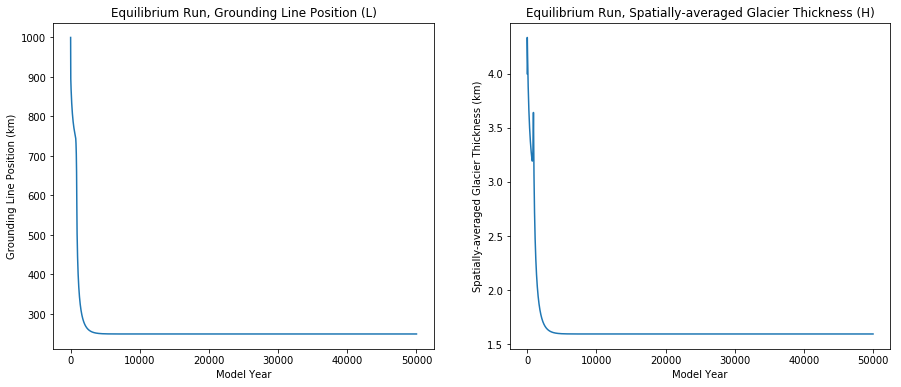

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(np.arange(nt_eq),xg_eq/1e3)
plt.xlabel('Model Year')
plt.ylabel('Grounding Line Position (km)')
plt.title('Equilibrium Run, Grounding Line Position (L)')
plt.axis('tight')

plt.subplot(1,2,2)
plt.plot(np.arange(nt_eq),h_eq/1e3)
plt.xlabel('Model Year')
plt.ylabel('Spatially-averaged Glacier Thickness (km)')
plt.title('Equilibrium Run, Spatially-averaged Glacier Thickness (H)')
plt.axis('tight')
plt.show()

# Model Run "r1": Retrograde Slope w/ Uncertainty in Mean Ocean Forcing ($\eta$), Pink Shading in Robel et al. (2019) Fig. 2

Define initial conditions stored from equilibrated model run...

In [14]:
# take values from the final time point of the equilibrium model
Q_g0 = Q_g
xg0 = xg_eq[-1]
h0 = h_eq[-1]
hg0 = hg
accum0 = accum
omega0 = omega

In [15]:
# update to slope parameters
parameters['sill_max'] = xg0-10
parameters['sill_min'] = -500e3
parameters['sill_slope'] = 3.5e-3 # bx in Robel et al. 2019 (bed slope)
parameters['icedivide'] = b0_orig-(parameters['sill_slope']-parameters['bedslope'])*(parameters['sill_max']-parameters['sill_min'])

In [16]:
# define the number of years to the spin the model up
spinup_time = 500-1 # years to spin up the model

# define an accumulation during spin-up
spinup_accum = 0.006 # [m/yr]

# define standard deviation for the ocean-inducing melting (forcing) of the grounding line
eta_std = 50

Choose whether to run the analyses (ld_prev=0) or load the previously saved analyses (ld_prev=1)

In [17]:
# load in the package to save/load
import pickle
# a name for the file we will save/load (copied from Alex's code)
save_name_r1='Theorycomp_retro_uncertainmean.pk1'

# if the user chooses "ld_prev=0", re-run the analyses
if ld_prev==0:

    # create an object to time the design creation
    startTime = datetime.now()

    # get the noise values with a standard deviation defined above
    parameters['eta_noise'] = np.random.randn(n_ensemble)*eta_std

    # define array for the model
    xg_r1 = np.empty((n_ensemble,nt),dtype='float64') # Grounding line position
    Qg_r1 = np.empty((n_ensemble,nt),dtype='float64') # Ice-flux across the grounding line
    hg_r1 = np.empty((n_ensemble,nt),dtype='float64') # height at the grounding line

    # loop over ensemble members 
    for j in range(n_ensemble):

        # run each model iteration starting for the initial conditions
        xg = xg0
        hg = hg0
        accum = accum0
        omega = omega0
        theta = theta0
        Q_g = Q_g0
        eta_noise = 0

        xg_r1[j,0] = xg0
        Qg_r1[j,0] = Q_g0
        hg_r1[j,0] = hg0

        # loop and run the model
        for t in range(nt):

            b = Base_New(xg,parameters)

            # check to see if we are in the spin-up period
            if (t > spinup_time) and (j<n_ensemble): # (I think skipping j==n_ensemble is a bug here? But I've left it)
                eta_noise = parameters['eta_noise'][j]/np.sqrt(dt/year)

            else:
                accum = (accum0*year-spinup_accum*((t+1)/(spinup_time+1)))/year

            theta = theta0
            omega = ((A_glen*(rho_i*g)**(n+1) * (1-(rho_i/rho_w))**n / (4**n * C))**(1/(m+1))) * theta**(n/(m+1))

            # calculate the change in model values and update
            hg = -(rho_w/rho_i)*b   # grounding zone thickness
            Q_g = omega*(hg**beta)
            dxg_dt = (accum*xg - Q_g)/hg

            xg = xg + dxg_dt*dt + eta_noise

            # store the model values
            xg_r1[j,t] = xg
            Qg_r1[j,t] = Q_g
            hg_r1[j,t] = hg

        if (j % 100 == 0):
            print(j)

    # print the elapsed time to create the design
    print('Time Elapsed = '+str(datetime.now() - startTime))

    # store the training data
    xg_dat={'xg_r1': xg_r1, 'hg_r1': hg_r1, 'Qg_r1': Qg_r1, 'eta_noise': eta_noise}

    # save the data
    pickle.dump(xg_dat, open( "./"+save_name_r1, "wb" ) )

# else if ld_prev~=0, load the analyses
else:
    
    # load the data
    xg_dat=pickle.load(open( "./"+save_name_r1, "rb" ) )
    xg_r1=xg_dat['xg_r1']
    hg_r1=xg_dat['hg_r1']
    eta_noise=xg_dat['eta_noise']

### Plot the results

In [18]:
# make an anomaly array
xg_anom_r1=(xg_r1.T-xg_r1[:,spinup_time]).T

In [19]:
# create the time grid to make plots
time = np.arange(nt)+1-spinup_time-1
q_want=[5,25,50,75,95]
xg_quants = np.percentile(xg_anom_r1,q_want,axis=0)

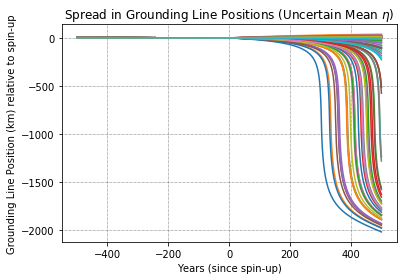

In [20]:
plt.figure()
plt.plot(time,(xg_anom_r1[nens_ss,:].T)/1e3)
plt.xlabel('Years (since spin-up)')
plt.ylabel('Grounding Line Position (km) relative to spin-up')
plt.title('Spread in Grounding Line Positions (Uncertain Mean $\eta$)')
plt.grid()
plt.show()

/home/dmg370/.local/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


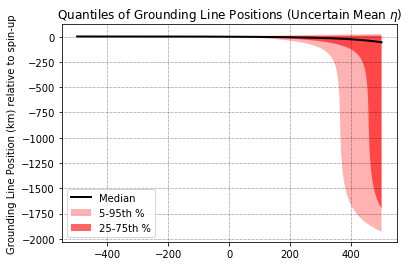

In [21]:
plt.figure(figsize=(6,4))
plt.grid()
plt.plot(time,xg_quants[2,:]/1e3,c='k',label='Median',lw=2)

ax = plt.subplot()
ax.fill_between(time, 
                    y1=xg_quants[0,:]/1e3,
                    y2=xg_quants[4,:]/1e3,
                    alpha=0.3, facecolor='r',label='5-95th %')

ax.fill_between(time, 
                    y1=xg_quants[1,:]/1e3,
                    y2=xg_quants[3,:]/1e3,
                    alpha=0.6, facecolor='r',label='25-75th %')

plt.ylabel('Grounding Line Position (km) relative to spin-up')
plt.title('Quantiles of Grounding Line Positions (Uncertain Mean $\eta$)')
plt.legend(loc='best')
plt.show()

## Compare w/ Prediction for "r1"

Now compare the results from the numerical model above with the analytical solutions.

In [22]:
check_i=-2

In [23]:
# fix the accumulation to calculate things
accum=(accum0*year-spinup_accum*((t+1)/(spinup_time+1)))/year

t_lin = np.linspace((-spinup_time-1)*year,(nt-spinup_time-1)*year,nt)

c = float(lamda*parameters['sill_slope']*(accum*(hg0**(-2))*xg0 + (beta-1)*omega*hg0**(beta-2)) + accum/hg0)
sigma_xg_lin = np.sqrt((1/(2*c))*(np.exp(2*c*t_lin)-1))*(eta_std/np.sqrt(year))

ts_noise = np.linspace(0,(nt-spinup_time-1)*year,(nt-spinup_time-1))
c_nl = lamda*parameters['sill_slope']*(accum*(hg_r1[check_i,:]**(-2))*xg_r1[check_i,:] + \
                                       (beta-1)*omega*hg_r1[check_i,:]**(beta-2)) + \
                                        (accum/hg_r1[check_i,:])

/home/dmg370/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


In [24]:
from scipy import integrate
from scipy import stats
I_nl = integrate.cumtrapz(c_nl[spinup_time+1:],ts_noise,initial=0)
sigma_xg_nl = np.sqrt(np.exp(2*I_nl) * integrate.cumtrapz(np.exp(-2.*I_nl),ts_noise,initial=0))

In [25]:
d = (lamda*parameters['sill_slope']/hg0)**2 * (accum*(xg0/hg0) + \
                                               (accum/(lamda*parameters['sill_slope'])) - \
                                               0.5*(beta-1)*(beta-2)*omega*(hg0**(beta-1)))

d_nl = (lamda*parameters['sill_slope']/hg_r1[check_i,:])**2 * (accum*(xg_r1[check_i,:]/hg_r1[check_i,:]) + \
                                               (accum/(lamda*parameters['sill_slope'])) - \
                                               0.5*(beta-1)*(beta-2)*omega*(hg_r1[check_i,:]**(beta-1)))

S = np.exp(3*I_nl) * integrate.cumtrapz((sigma_xg_nl**4)*np.exp(-3*I_nl),ts_noise,initial=0)
M = np.exp(I_nl) * integrate.cumtrapz((sigma_xg_nl**2)*np.exp(-I_nl),ts_noise,initial=0)

skew_xg_nl  = 6*(M/(np.sqrt(np.exp(2*I_nl) \
                          * integrate.cumtrapz(np.exp(-2*I_nl),ts_noise,initial=0)))) \
                          * (eta_std/np.sqrt(year))*d_nl[spinup_time+1:].T

/home/dmg370/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


In [26]:
# store the statistics
stats_r1={'std':sigma_xg_nl, 'skew':skew_xg_nl}

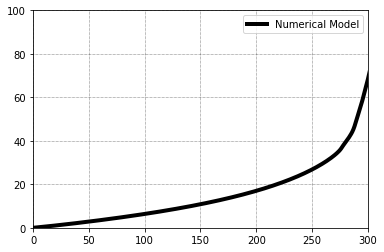

In [27]:
plt.figure()
#plt.plot(ts_noise/year,sigma_xg_nl*(eta_std/np.sqrt(year))/1e3,'o',label='Linear Prediction')
plt.plot(time[spinup_time+1:],np.sqrt(stats.moment(xg_r1[:,spinup_time+1:].T/1e3,moment=2,axis=1,nan_policy='propagate')),'k',label='Numerical Model',lw=4)
#plt.plot(ts_noise/year,(sigma_xg_nl*eta_std/np.sqrt(year))/1e3,'ro',markersize=5,label='Theory Prediction')

plt.xlim([0,300])
plt.ylim([0,100])
plt.legend(loc='best')
plt.grid()
plt.show()

# Model Run "r2": Retrograde Slope w/ Decadal Persistence ($\tau_F=10 yr$) in Ocean Forcing ($\eta$), Blue Shading in Robel et al. (2019) Fig. 2

In [28]:
# update to slope parameters
parameters['sill_max'] = xg0-10
parameters['sill_min'] = -300e3
parameters['sill_slope'] = 3.5e-3 # bx in Robel et al. 2019 (bed slope)
parameters['icedivide'] = b0_orig-(parameters['sill_slope']-parameters['bedslope'])*(parameters['sill_max']-parameters['sill_min'])

In [29]:
# define the number of years to the spin the model up
spinup_time = 500-1 # years to spin up the model

# define an accumulation during spin-up
spinup_accum = 0.006 # [m/yr]

# define standard deviation for the ocean-inducing melting (forcing) of the grounding line
# this will be combined with an autocorrelated timeseries below
eta_std = 100

# define the de-correlation time scale, in years
tau = 10 # [yr]

In [ ]:
# import the ARIMA code
from statsmodels.tsa.arima_process import ArmaProcess

In [ ]:
# load in the package to save/load
import pickle
# a name for the file we will save/load (copied from Alex's code)
save_name_r2='Theorycomp_retro_persistvar.pk1'

# if the user chooses "ld_prev=0", re-run the analyses
if ld_prev==0:

    # create an object to time the design creation
    startTime = datetime.now()

    # define array for the model
    xg_r2 = np.empty((n_ensemble,nt),dtype='float64') # Grounding line position
    Qg_r2 = np.empty((n_ensemble,nt),dtype='float64') # Ice-flux across the grounding line
    hg_r2 = np.empty((n_ensemble,nt),dtype='float64') # height at the grounding line

    # loop over ensemble members 
    for j in range(n_ensemble):

        # run each model iteration starting for the initial conditions
        xg = xg0
        hg = hg0
        accum = accum0
        omega = omega0
        theta = theta0
        Q_g = Q_g0
        
        # get the autocorrelated noise values with a standard deviation 
        # and decorrelation time scale defined above

        # see example for use at: https://campus.datacamp.com/courses/introduction-to-time-series-analysis-in-python/autoregressive-ar-models?ex=2
        # create the AR(1) process with lag-zero correlation = 1.0, and lag-one correlation of 1-(1/tau)=0.9
        ar = np.array([1, -(1-(1/tau))])
        ma = np.array([ar[0]])
        AR_object = ArmaProcess(ar, ma)
        simulated_ts = AR_object.generate_sample(nsample=1000)

        # scale the result (and plot if you want to compare with exogenous code)
        parameters['eta_noise'] = simulated_ts*(eta_std/np.std(simulated_ts))
#         plt.plot(parameters['eta_noise'])
        
        eta_noise = 0

        xg_r2[j,0] = xg0
        Qg_r2[j,0] = Q_g0
        hg_r2[j,0] = hg0

        # loop and run the model
        for t in range(nt):

            b = Base_New(xg,parameters)

            # check to see if we are in the spin-up period
            if (t > spinup_time):
                eta_noise = parameters['eta_noise'][t]/np.sqrt(dt/year)

            else:
                accum = (accum0*year-spinup_accum*((t+1)/(spinup_time+1)))/year

            theta = theta0
            omega = ((A_glen*(rho_i*g)**(n+1) * (1-(rho_i/rho_w))**n / (4**n * C))**(1/(m+1))) * theta**(n/(m+1))

            # calculate the change in model values and update
            hg = -(rho_w/rho_i)*b   # grounding zone thickness
            Q_g = omega*(hg**beta)
            dxg_dt = (accum*xg - Q_g)/hg

            xg = xg + dxg_dt*dt + eta_noise

            # store the model values
            xg_r2[j,t] = xg
            Qg_r2[j,t] = Q_g
            hg_r2[j,t] = hg

        if (j % 100 == 0):
            print(j)

    # print the elapsed time to create the design
    print('Time Elapsed = '+str(datetime.now() - startTime))

    # store the training data
    xg_dat={'xg_r2': xg_r2, 'hg_r2': hg_r2, 'Qg_r2': Qg_r2, 'eta_noise': eta_noise}

    # save the data
    pickle.dump(xg_dat, open( "./"+save_name_r2, "wb" ) )

# else if ld_prev~=0, load the analyses
else:
    
    # load the data
    xg_dat=pickle.load(open( "./"+save_name_r2, "rb" ) )
    xg_r2=xg_dat['xg_r2']
    hg_r2=xg_dat['hg_r2']
    eta_noise=xg_dat['eta_noise']

### Plot the results

In [ ]:
# make an anomaly array
xg_anom_r2=(xg_r2.T-xg_r2[:,spinup_time]).T

In [ ]:
# create the time grid to make plots
xg_quants_r2 = np.percentile(xg_anom_r2,q_want,axis=0)

In [ ]:
plt.figure()
plt.plot(time,(xg_anom_r2[nens_ss,:].T)/1e3)
plt.xlabel('Years (since spin-up)')
plt.ylabel('Grounding Line Position (km) relative to spin-up')
plt.title('Spread in Grounding Line Positions (Interdecadal Variability)')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
plt.grid()
plt.plot(time,xg_quants_r2[2,:]/1e3,c='k',label='Median',lw=2)

ax = plt.subplot()
ax.fill_between(time, 
                    y1=xg_quants_r2[0,:]/1e3,
                    y2=xg_quants_r2[4,:]/1e3,
                    alpha=0.3, facecolor='b',label='5-95th %')

ax.fill_between(time, 
                    y1=xg_quants_r2[1,:]/1e3,
                    y2=xg_quants_r2[3,:]/1e3,
                    alpha=0.6, facecolor='b',label='25-75th %')

plt.ylabel('Grounding Line Position (km) relative to spin-up')
plt.title('Quantiles of Grounding Line Positions (Interdecadal Variability)')
plt.legend(loc='best')
plt.show()

## Compare w/ Prediction for "r2"

In [ ]:
check_i=-1

In [ ]:
# fix the accumulation to calculate things
accum=accum0

t_lin = np.linspace((-spinup_time-1)*year,(nt-spinup_time-1)*year,nt)

c = float(lamda*parameters['sill_slope']*(accum*(hg0**(-2))*xg0 + (beta-1)*omega*hg0**(beta-2)) + accum/hg0)
sigma_xg_lin = np.sqrt((1/(2*c))*(np.exp(2*c*t_lin)-1))*(eta_std/np.sqrt(year))

ts_noise = np.linspace(0,(nt-spinup_time-1)*year,(nt-spinup_time-1))
c_nl = lamda*parameters['sill_slope']*(accum*(hg_r2[check_i,:]**(-2))*xg_r2[check_i,:] + \
                                       (beta-1)*omega*hg_r2[check_i,:]**(beta-2)) + \
                                        (accum/hg_r2[check_i,:])

In [ ]:
I_nl = integrate.cumtrapz(c_nl[spinup_time+1:],ts_noise,initial=0)
sigma_xg_nl = np.sqrt(2*tau*year/dt - 1)*np.sqrt(np.exp(2*I_nl) * integrate.cumtrapz(np.exp(-2.*I_nl),ts_noise,initial=0))


In [ ]:
d = (lamda*parameters['sill_slope']/hg0)**2 * (accum*(xg0/hg0) + \
                                               (accum/(lamda*parameters['sill_slope'])) - \
                                               0.5*(beta-1)*(beta-2)*omega*(hg0**(beta-1)))

d_nl = (lamda*parameters['sill_slope']/hg_r2[check_i,:])**2 * (accum*(xg_r2[check_i,:]/hg_r2[check_i,:]) + \
                                               (accum/(lamda*parameters['sill_slope'])) - \
                                               0.5*(beta-1)*(beta-2)*omega*(hg_r2[check_i,:]**(beta-1)))

S = np.exp(3*I_nl) * integrate.cumtrapz((sigma_xg_nl**4)*np.exp(-3*I_nl),ts_noise,initial=0)
M = np.exp(I_nl) * integrate.cumtrapz((sigma_xg_nl**2)*np.exp(-I_nl),ts_noise,initial=0)

skew_xg_nl  = 6*(M/(np.sqrt(np.exp(2*I_nl) \
                          * integrate.cumtrapz(np.exp(-2*I_nl),ts_noise,initial=0)))) \
                          * (eta_std/np.sqrt(year))*d_nl[spinup_time+1:].T

In [ ]:
# store the statistics
stats_r2={'std':sigma_xg_nl, 'skew':skew_xg_nl}

In [ ]:
plt.figure()
#plt.plot(ts_noise/year,sigma_xg_nl*(eta_std/np.sqrt(year))/1e3,'o',label='Linear Prediction')
plt.plot(time[spinup_time+1:],np.sqrt(stats.moment(xg_r2[:,spinup_time+1:].T/1e3,moment=2,axis=1,nan_policy='propagate')),'k--',label='Numerical Model',lw=4)
plt.plot(ts_noise/year,(sigma_xg_nl*eta_std/np.sqrt(year))/1e3,'bo',markersize=5,label='Theory Prediction')
plt.xlim([0,300])
plt.ylim([0,100])
plt.legend(loc='best')
plt.grid()
plt.show()

# Model Run "r3": Retrograde Slope w/ Interannual Variability (year-to-year gaussian) in Ocean Forcing ($\eta$), Orange Shading in Robel et al. (2019) Fig. 2

In [ ]:
# update to slope parameters
parameters['sill_max'] = xg0-10
parameters['sill_min'] = 0
parameters['sill_slope'] = 3.5e-3 # bx in Robel et al. 2019 (bed slope)
parameters['icedivide'] = b0_orig-(parameters['sill_slope']-parameters['bedslope'])*(parameters['sill_max']-parameters['sill_min'])

In [ ]:
# define the number of years to the spin the model up
spinup_time = 500-1 # years to spin up the model

# define an accumulation during spin-up
spinup_accum = 0.006 # [m/yr]

# define standard deviation for the ocean-inducing melting (forcing) of the grounding line
# this is now a white-noise which is applied to the timeseries
eta_std = 100

In [ ]:
# load in the package to save/load
import pickle
# a name for the file we will save/load (copied from Alex's code)
save_name_r3='Theorycomp_retro_whitevar.pk1'

# if the user chooses "ld_prev=0", re-run the analyses
if ld_prev==0:

    # create an object to time the design creation
    startTime = datetime.now()

    # define array for the model
    xg_r3 = np.empty((n_ensemble,nt),dtype='float64') # Grounding line position
    Qg_r3 = np.empty((n_ensemble,nt),dtype='float64') # Ice-flux across the grounding line
    hg_r3 = np.empty((n_ensemble,nt),dtype='float64') # height at the grounding line

    # loop over ensemble members 
    for j in range(n_ensemble):

        # run each model iteration starting for the initial conditions
        xg = xg0
        hg = hg0
        accum = accum0
        omega = omega0
        theta = theta0
        Q_g = Q_g0
        
        # create the noise timeseries as a Gaussian noise with no auto-correlation
        parameters['eta_noise'] = np.random.randn(nt)*eta_std
        eta_noise = 0

        xg_r3[j,0] = xg0
        Qg_r3[j,0] = Q_g0
        hg_r3[j,0] = hg0

        # loop and run the model
        for t in range(nt):

            b = Base_New(xg,parameters)

            # check to see if we are in the spin-up period
            if (t > spinup_time):
                eta_noise = parameters['eta_noise'][t]/np.sqrt(dt/year)

            else:
                accum = (accum0*year-spinup_accum*((t+1)/(spinup_time+1)))/year

            theta = theta0
            omega = ((A_glen*(rho_i*g)**(n+1) * (1-(rho_i/rho_w))**n / (4**n * C))**(1/(m+1))) * theta**(n/(m+1))

            # calculate the change in model values and update
            hg = -(rho_w/rho_i)*b   # grounding zone thickness
            Q_g = omega*(hg**beta)
            dxg_dt = (accum*xg - Q_g)/hg

            xg = xg + dxg_dt*dt + eta_noise

            # store the model values
            xg_r3[j,t] = xg
            Qg_r3[j,t] = Q_g
            hg_r3[j,t] = hg

        if (j % 100 == 0):
            print(j)

    # print the elapsed time to create the design
    print('Time Elapsed = '+str(datetime.now() - startTime))

    # store the training data
    xg_dat={'xg_r3': xg_r3, 'hg_r3': hg_r3, 'Qg_r3': Qg_r3, 'eta_noise': eta_noise}

    # save the data
    pickle.dump(xg_dat, open( "./"+save_name_r3, "wb" ) )

# else if ld_prev~=0, load the analyses
else:
    
    # load the data
    xg_dat=pickle.load(open( "./"+save_name_r3, "rb" ) )
    xg_r3=xg_dat['xg_r3']
    hg_r3=xg_dat['hg_r3']
    eta_noise=xg_dat['eta_noise']

In [ ]:
# make an anomaly array
xg_anom_r3=(xg_r3.T-xg_r3[:,spinup_time]).T

In [ ]:
# create the time grid to make plots
xg_quants_r3 = np.percentile(xg_anom_r3,q_want,axis=0)

In [ ]:
plt.figure()
plt.plot(time,(xg_anom_r3[nens_ss,:].T)/1e3)
plt.xlabel('Years (since spin-up)')
plt.ylabel('Grounding Line Position (km) relative to spin-up')
plt.title('Spread in Grounding Line Positions (Interannual Variability)')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
plt.grid()
plt.plot(time,xg_quants_r3[2,:]/1e3,c='k',label='Median',lw=2)

ax = plt.subplot()
ax.fill_between(time, 
                    y1=xg_quants_r3[0,:]/1e3,
                    y2=xg_quants_r3[4,:]/1e3,
                    alpha=0.3, facecolor='orange',label='5-95th %')

ax.fill_between(time, 
                    y1=xg_quants_r3[1,:]/1e3,
                    y2=xg_quants_r3[3,:]/1e3,
                    alpha=0.6, facecolor='orange',label='25-75th %')

plt.ylabel('Grounding Line Position (km) relative to spin-up')
plt.title('Quantiles of Grounding Line Positions (Interannual Variability)')
plt.legend(loc='best')
plt.show()

## Compare w/ Prediction for "r3"

In [ ]:
check_i=-1

In [ ]:
# fix the accumulation to calculate things
accum=accum0

t_lin = np.linspace((-spinup_time-1)*year,(nt-spinup_time-1)*year,nt)

c = float(lamda*parameters['sill_slope']*(accum*(hg0**(-2))*xg0 + (beta-1)*omega*hg0**(beta-2)) + accum/hg0)
sigma_xg_lin = np.sqrt((1/(2*c))*(np.exp(2*c*t_lin)-1))*(eta_std/np.sqrt(year))

ts_noise = np.linspace(0,(nt-spinup_time-1)*year,(nt-spinup_time-1))
c_nl = lamda*parameters['sill_slope']*(accum*(hg_r3[check_i,:]**(-2))*xg_r3[check_i,:] + \
                                       (beta-1)*omega*hg_r3[check_i,:]**(beta-2)) + \
                                        (accum/hg_r3[check_i,:])

In [ ]:
I_nl = integrate.cumtrapz(c_nl[spinup_time+1:],ts_noise,initial=0)
sigma_xg_nl = np.sqrt(np.exp(2*I_nl) * integrate.cumtrapz(np.exp(-2.*I_nl),ts_noise,initial=0))

In [ ]:
d = (lamda*parameters['sill_slope']/hg0)**2 * (accum*(xg0/hg0) + \
                                               (accum/(lamda*parameters['sill_slope'])) - \
                                               0.5*(beta-1)*(beta-2)*omega*(hg0**(beta-1)))

d_nl = (lamda*parameters['sill_slope']/hg_r3[check_i,:])**2 * (accum*(xg_r3[check_i,:]/hg_r3[check_i,:]) + \
                                               (accum/(lamda*parameters['sill_slope'])) - \
                                               0.5*(beta-1)*(beta-2)*omega*(hg_r3[check_i,:]**(beta-1)))

S = np.exp(3*I_nl) * integrate.cumtrapz((sigma_xg_nl**4)*np.exp(-3*I_nl),ts_noise,initial=0)
M = np.exp(I_nl) * integrate.cumtrapz((sigma_xg_nl**2)*np.exp(-I_nl),ts_noise,initial=0)

skew_xg_nl  = 6*(M/(np.sqrt(np.exp(2*I_nl) \
                          * integrate.cumtrapz(np.exp(-2*I_nl),ts_noise,initial=0)))) \
                          * (eta_std/np.sqrt(year))*d_nl[spinup_time+1:].T

In [ ]:
# store the statistics
stats_r3={'std':sigma_xg_nl, 'skew':skew_xg_nl}

In [ ]:
plt.figure()
#plt.plot(ts_noise/year,sigma_xg_nl*(eta_std/np.sqrt(year))/1e3,'o',label='Linear Prediction')
plt.plot(time[spinup_time+1:],np.sqrt(stats.moment(xg_r3[:,spinup_time+1:].T/1e3,moment=2,axis=1,nan_policy='propagate')),'k--',label='Numerical Model',lw=4)
plt.plot(ts_noise/year,(sigma_xg_nl*eta_std/np.sqrt(year))/1e3,'o',color='orange',markersize=5,label='Theory Prediction')
plt.xlim([0,300])
plt.ylim([0,20])
plt.legend(loc='best')
plt.grid()
plt.show()

# Model Run "r4": Forward Bed (Prograde) Slope w/ Interannual Variability (year-to-year gaussian) in Ocean Forcing ($\eta$), Green Shading in Robel et al. (2019) Fig. 2

In [ ]:
# update to slope parameters
parameters['sill_max'] = xg0+100e3
parameters['sill_min'] = xg0+99e3
parameters['sill_slope'] = -1e-3 # bx in Robel et al. 2019 (bed slope)
parameters['icedivide'] = b0_orig-(parameters['sill_slope']-parameters['bedslope'])*(parameters['sill_max']-parameters['sill_min'])

In [ ]:
# define the number of years to the spin the model up
spinup_time = 500-1 # years to spin up the model

# define an accumulation during spin-up
spinup_accum = 0.006 # [m/yr]

# define standard deviation for the ocean-inducing melting (forcing) of the grounding line
# this is now a white-noise which is applied to the timeseries
eta_std = 100

In [ ]:
# load in the package to save/load
import pickle
# a name for the file we will save/load (copied from Alex's code)
save_name_r4='Theorycomp_pro_whitevar.pk1'

# if the user chooses "ld_prev=0", re-run the analyses
if ld_prev==0:

    # create an object to time the design creation
    startTime = datetime.now()

    # define array for the model
    xg_r4 = np.empty((n_ensemble,nt),dtype='float64') # Grounding line position
    Qg_r4 = np.empty((n_ensemble,nt),dtype='float64') # Ice-flux across the grounding line
    hg_r4 = np.empty((n_ensemble,nt),dtype='float64') # height at the grounding line

    # loop over ensemble members 
    for j in range(n_ensemble):

        # run each model iteration starting for the initial conditions
        xg = xg0
        hg = hg0
        accum = accum0
        omega = omega0
        theta = theta0
        Q_g = Q_g0
        
        # create the noise timeseries as a Gaussian noise with no auto-correlation
        parameters['eta_noise'] = np.random.randn(nt)*eta_std
        eta_noise = 0

        xg_r4[j,0] = xg0
        Qg_r4[j,0] = Q_g0
        hg_r4[j,0] = hg0

        # loop and run the model
        for t in range(nt):

            b = Base_New(xg,parameters)

            # check to see if we are in the spin-up period
            if (t > spinup_time):
                eta_noise = parameters['eta_noise'][t]/np.sqrt(dt/year)

            else:
                accum = (accum0*year-spinup_accum*((t+1)/(spinup_time+1)))/year

            theta = theta0
            omega = ((A_glen*(rho_i*g)**(n+1) * (1-(rho_i/rho_w))**n / (4**n * C))**(1/(m+1))) * theta**(n/(m+1))

            # calculate the change in model values and update
            hg = -(rho_w/rho_i)*b   # grounding zone thickness
            Q_g = omega*(hg**beta)
            dxg_dt = (accum*xg - Q_g)/hg

            xg = xg + dxg_dt*dt + eta_noise

            # store the model values
            xg_r4[j,t] = xg
            Qg_r4[j,t] = Q_g
            hg_r4[j,t] = hg

        if (j % 100 == 0):
            print(j)

    # print the elapsed time to create the design
    print('Time Elapsed = '+str(datetime.now() - startTime))

    # store the training data
    xg_dat={'xg_r4': xg_r4, 'hg_r4': hg_r4, 'Qg_r4': Qg_r4, 'eta_noise': eta_noise}

    # save the data
    pickle.dump(xg_dat, open( "./"+save_name_r4, "wb" ) )

# else if ld_prev~=0, load the analyses
else:
    
    # load the data
    xg_dat=pickle.load(open( "./"+save_name_r4, "rb" ) )
    xg_r4=xg_dat['xg_r4']
    hg_r4=xg_dat['hg_r4']
    eta_noise=xg_dat['eta_noise']

In [ ]:
# make an anomaly array
xg_anom_r4=(xg_r4.T-xg_r4[:,spinup_time]).T

In [ ]:
# create the time grid to make plots
xg_quants_r4 = np.percentile(xg_anom_r4,q_want,axis=0)

In [ ]:
plt.figure()
plt.plot(time,(xg_anom_r4[nens_ss,:].T)/1e3)
plt.xlabel('Years (since spin-up)')
plt.ylabel('Grounding Line Position (km) relative to spin-up')
plt.title('Spread in Grounding Line Positions (Prograde Slope, Interannual Variability)')
plt.grid()
plt.show()

In [ ]:
plt.figure(figsize=(6,4))
plt.grid()
plt.plot(time,xg_quants_r4[2,:]/1e3,c='k',label='Median',lw=2)

ax = plt.subplot()
ax.fill_between(time, 
                    y1=xg_quants_r4[0,:]/1e3,
                    y2=xg_quants_r4[4,:]/1e3,
                    alpha=0.3, facecolor='g',label='5-95th %')

ax.fill_between(time, 
                    y1=xg_quants_r4[1,:]/1e3,
                    y2=xg_quants_r4[3,:]/1e3,
                    alpha=0.6, facecolor='g',label='25-75th %')

plt.ylabel('Grounding Line Position (km) relative to spin-up')
plt.title('Quantiles of Grounding Line Positions (Prograde Slope, Interannual Variability)')
plt.legend(loc='best')
plt.show()

## Compare w/ Prediction for "r4"

In [ ]:
check_i=-1

In [ ]:
# fix the accumulation to calculate things
accum=accum0

t_lin = np.linspace((-spinup_time-1)*year,(nt-spinup_time-1)*year,nt)

c = float(lamda*parameters['sill_slope']*(accum*(hg0**(-2))*xg0 + (beta-1)*omega*hg0**(beta-2)) + accum/hg0)
sigma_xg_lin = np.sqrt((1/(2*c))*(np.exp(2*c*t_lin)-1))*(eta_std/np.sqrt(year))

ts_noise = np.linspace(0,(nt-spinup_time-1)*year,(nt-spinup_time-1))
c_nl = lamda*parameters['sill_slope']*(accum*(hg_r4[check_i,:]**(-2))*xg_r4[check_i,:] + \
                                       (beta-1)*omega*hg_r4[check_i,:]**(beta-2)) + \
                                        (accum/hg_r4[check_i,:])

In [ ]:
I_nl = integrate.cumtrapz(c_nl[spinup_time+1:],ts_noise,initial=0)
sigma_xg_nl = np.sqrt(np.exp(2*I_nl) * integrate.cumtrapz(np.exp(-2.*I_nl),ts_noise,initial=0))

In [ ]:
d = (lamda*parameters['sill_slope']/hg0)**2 * (accum*(xg0/hg0) + \
                                               (accum/(lamda*parameters['sill_slope'])) - \
                                               0.5*(beta-1)*(beta-2)*omega*(hg0**(beta-1)))

d_nl = (lamda*parameters['sill_slope']/hg_r4[check_i,:])**2 * (accum*(xg_r4[check_i,:]/hg_r4[check_i,:]) + \
                                               (accum/(lamda*parameters['sill_slope'])) - \
                                               0.5*(beta-1)*(beta-2)*omega*(hg_r4[check_i,:]**(beta-1)))

S = np.exp(3*I_nl) * integrate.cumtrapz((sigma_xg_nl**4)*np.exp(-3*I_nl),ts_noise,initial=0)
M = np.exp(I_nl) * integrate.cumtrapz((sigma_xg_nl**2)*np.exp(-I_nl),ts_noise,initial=0)

skew_xg_nl  = 6*(M/(np.sqrt(np.exp(2*I_nl) \
                          * integrate.cumtrapz(np.exp(-2*I_nl),ts_noise,initial=0)))) \
                          * (eta_std/np.sqrt(year))*d_nl[spinup_time+1:].T

In [ ]:
# store the statistics
stats_r4={'std':sigma_xg_nl, 'skew':skew_xg_nl}

In [ ]:
plt.figure()
#plt.plot(ts_noise/year,sigma_xg_nl*(eta_std/np.sqrt(year))/1e3,'o',label='Linear Prediction')
plt.plot(time[spinup_time+1:],np.sqrt(stats.moment(xg_r4[:,spinup_time+1:].T/1e3,moment=2,axis=1,nan_policy='propagate')),'k--',label='Numerical Model',lw=4)
plt.plot(ts_noise/year,(sigma_xg_nl*eta_std/np.sqrt(year))/1e3,'go',markersize=5,label='Theory Prediction')
plt.xlim([0,300])
plt.ylim([0,20])
plt.legend(loc='best')
plt.grid()
plt.show()

# Show Results Combined (Robel et al. 2019, Figure 2)

In [ ]:
time[0::49].shape

In [ ]:
stats_r1['std'][0::49].shape

In [ ]:
robel_fig2, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10,12))
plt.xlim([0,300])
plt.xlabel('Time (Years)')

ax1.plot(time,xg_quants[2,:],c='white')
ax1.grid()
ax1.fill_between(time, xg_quants[1,:]/1e3, xg_quants[3,:]/1e3, color='plum', label='Reverse bed, uncertain mean')
ax1.fill_between(time, xg_quants_r2[1,:]/1e3, xg_quants_r2[3,:]/1e3, color='royalblue', label='Reverse bed, interdecal var.')
ax1.fill_between(time, xg_quants_r3[1,:]/1e3, xg_quants_r3[3,:]/1e3, color='orange', label='Reverse bed, interannual var.')
ax1.fill_between(time, xg_quants_r4[1,:]/1e3, xg_quants_r4[3,:]/1e3, color='g', label='Forward bed, interannual var.')
ax1.set_ylim(-60,20)
ax1.legend(loc='lower left')
ax1.set_ylabel('25-75%ile Projection Range (km)')

ax2.grid()
ax2.plot(time,np.sqrt(stats.moment(xg_r1.T/1e3,moment=2,axis=1,nan_policy='propagate')),color='plum',label='Reverse bed, uncertain mean',lw=3)
ax2.plot(time,np.sqrt(stats.moment(xg_r2.T/1e3,moment=2,axis=1,nan_policy='propagate')),color='royalblue',label='Reverse bed, interdecal var.',lw=3)
ax2.plot(time,np.sqrt(stats.moment(xg_r3.T/1e3,moment=2,axis=1,nan_policy='propagate')),color='orange',label='Reverse bed, interannual var.',lw=3)
ax2.plot(time,np.sqrt(stats.moment(xg_r4.T/1e3,moment=2,axis=1,nan_policy='propagate')),color='g', label='Forward bed, interannual var.',lw=3)
ax2.scatter(time[10*49::49],(stats_r1['std'][0::49]*50/np.sqrt(year))/1e3,color='plum',s=100,facecolors='none',lw=3)
ax2.scatter(time[10*49::49],(stats_r2['std'][0::49]*100/np.sqrt(year))/1e3,color='royalblue',s=100,facecolors='none',lw=3)
ax2.scatter(time[10*49::49],(stats_r3['std'][0::49]*100/np.sqrt(year))/1e3,color='orange',s=100,facecolors='none',lw=3)
ax2.scatter(time[10*49::49],(stats_r4['std'][0::49]*100/np.sqrt(year))/1e3,color='g',s=100,facecolors='none',lw=3)
ax2.set_ylim(-10,80)
ax2.set_ylabel('Uncertainty $\sigma_L$ (km)')

ax3.grid()
ax3.plot(time,stats.moment(xg_r1.T/1e3,moment=3,axis=1,nan_policy='propagate'),color='plum',label='Reverse bed, uncertain mean',lw=3)
ax3.plot(time,stats.moment(xg_r2.T/1e3,moment=3,axis=1,nan_policy='propagate'),color='royalblue',label='Reverse bed, interdecal var.',lw=3)
ax3.plot(time,stats.moment(xg_r3.T/1e3,moment=3,axis=1,nan_policy='propagate'),color='orange',label='Reverse bed, interannual var.',lw=3)
ax3.plot(time,stats.moment(xg_r4.T/1e3,moment=3,axis=1,nan_policy='propagate'),color='g', label='Forward bed, interannual var.',lw=3)
ax3.scatter(time[10*49::49],stats_r1['skew'][0::49],color='plum',s=100,facecolors='none',lw=3)
ax3.scatter(time[10*49::49],stats_r2['skew'][0::49],color='royalblue',s=100,facecolors='none',lw=3)
ax3.scatter(time[10*49::49],stats_r3['skew'][0::49],color='orange',s=100,facecolors='none',lw=3)
ax3.scatter(time[10*49::49],stats_r4['skew'][0::49],color='g',s=100,facecolors='none',lw=3)
ax3.set_ylim(-2,1)
ax3.set_ylabel('Skewness')

plt.show()